# Requerimiento 2: Análisis de Similitud entre Artículos

## Descripción del Requerimiento

Este notebook implementa un **análisis comparativo de algoritmos de similitud textual** para evaluar la similitud entre abstracts de artículos científicos.

### Objetivos:
1. Cargar y preprocesar archivo BibTeX consolidado
2. Eliminar duplicados por título
3. Comparar 6 algoritmos de similitud textual

### Categorías de Algoritmos:

#### Algoritmos Clásicos (No supervisados):
1. **Levenshtein**: Distancia de edición entre caracteres
2. **Coseno TF-IDF**: Similitud vectorial con pesos TF-IDF
3. **Jaccard**: Intersección de conjuntos de palabras
4. **Euclidiana**: Distancia en espacio vectorial

#### Algoritmos Basados en IA (Supervisados):
5. **SBERT**: Embeddings semánticos con Sentence-BERT
6. **Cross-Encoder**: Evaluación directa de pares de texto

### Umbrales de Interpretación:

| Rango | Interpretación |
|-------|----------------|
| ≥ 0.80 | Muy similares |
| 0.50 - 0.79 | Similitud moderada |
| 0.20 - 0.49 | Poco similares |
| < 0.20 | No similares |

# 1. Carga y Deduplicación del Archivo BibTeX

Esta celda carga el archivo consolidado y elimina artículos duplicados.

#### Proceso:

##### 1. Configuración del Parser
```python
parser = bibtexparser.bparser.BibTexParser(common_strings=True)
parser.expect_multiple_parse = True
```
- **`common_strings=True`**: Expande abreviaturas comunes de BibTeX
- **`expect_multiple_parse=True`**: Suprime warnings de múltiples entradas

##### 2. Lectura del Archivo
```python
with open(CONSOLIDADO_PATH, encoding="utf-8") as f:
    bib_database = bibtexparser.load(f, parser=parser)
```
- **Encoding UTF-8**: Soporta caracteres especiales
- **Context manager**: Cierre automático del archivo

##### 3. Extracción de Campos
```python
for entry in bib_database.entries:
    data.append({
        "title": entry.get("title", "").strip(),
        "authors": entry.get("author", ""),
        "keywords": entry.get("keywords", ""),
        "abstract": entry.get("abstract", "")
    })
```
- Extrae título, autores, keywords y abstract
- Manejo de valores faltantes con `entry.get(campo, "")`

##### 4. Deduplicación por Título
```python
df_unique = df.drop_duplicates(subset="title", keep="first")
```
- **`keep="first"`**: Mantiene la primera aparición de cada título
- Los títulos son únicos en publicaciones académicas

##### 5. Guardado de Resultados
```python
df_unique.to_csv("articulos_unicos.csv", index=False)
df_duplicates.to_csv("articulos_repetidos.csv", index=False)
```
- **`articulos_unicos.csv`**: Dataset limpio para análisis
- **`articulos_repetidos.csv`**: Duplicados para auditoría

In [9]:
import bibtexparser
import pandas as pd
import os
from dotenv import load_dotenv

# Cargar variables de entorno
load_dotenv()

# Obtener ruta del archivo consolidado
CONSOLIDADO_PATH = os.getenv("CONSOLIDADO_PATH", "../salidas/consolidado.bib")

# Verificar que el archivo existe
if not os.path.exists(CONSOLIDADO_PATH):
    print(f"Error: No se encuentra el archivo en {CONSOLIDADO_PATH}")
    print(f"Directorio actual: {os.getcwd()}")
    print(f"Archivos disponibles:")
    # Buscar archivos .bib en directorios comunes
    for root, dirs, files in os.walk(".."):
        for file in files:
            if file.endswith("consolidado.bib"):
                print(f"Encontrado: {os.path.join(root, file)}")
    raise FileNotFoundError(f"No se encuentra {CONSOLIDADO_PATH}")

print(f"Leyendo archivo: {CONSOLIDADO_PATH}")

# Configurar el parser
parser = bibtexparser.bparser.BibTexParser(common_strings=True)
parser.expect_multiple_parse = True  # Evita el warning

# Leer TODO el archivo de una vez
with open(CONSOLIDADO_PATH, encoding="utf-8") as f:
    bib_database = bibtexparser.load(f, parser=parser)

# Extraer la información
data = []
for entry in bib_database.entries:
    data.append({
        "title": entry.get("title", "").strip(),
        "authors": entry.get("author", ""),
        "keywords": entry.get("keywords", ""),
        "abstract": entry.get("abstract", "")
    })

df = pd.DataFrame(data)

# Eliminar duplicados por título
df_unique = df.drop_duplicates(subset="title", keep="first")
df_duplicates = df[df.duplicated(subset="title", keep=False)]

# Guardar resultados
df_unique.to_csv("articulos_unicos.csv", index=False)
df_duplicates.to_csv("articulos_repetidos.csv", index=False)

print(f"Artículos totales: {len(df)}")
print(f"Artículos únicos: {len(df_unique)}")
print(f"Artículos repetidos: {len(df_duplicates)}")

df_unique.head()

Leyendo archivo: /home/nop/Documentos/proyectoAnalisisAlgoritmos/proyecto/consolidado.bib
Artículos totales: 10226
Artículos únicos: 10189
Artículos repetidos: 38


,title,authors,keywords,abstract
0,Do Robots Dream of Passing a Programming Course?,"Torres, Nicolás",Training;Computational modeling;Instruments;Na...,Programming typically involves humans formulat...
1,WeAIR: Wearable Swarm Sensors for Air Quality ...,"Dimitri, Giovanna Maria and Parri, Lorenzo and...",Temperature measurement;Climate change;Cloud c...,The present study proposes the implementation ...
2,Discriminative-Generative Representation Learn...,"Li, Duanjiao and Chen, Yun and Zhang, Ying and...",Representation learning;Semantics;Asia;Self-su...,"Generative Adversarial Networks (GANs), as a f..."
3,3 Generative AI Models and LLM: Training Techn...,"Arun, C. and Karthick, S. and Selvakumara Samy...",,Generative artificial intelligence (AI) has be...
4,Virtual Human: A Comprehensive Survey on Acade...,"Cui, Lipeng and Liu, Jiarui",Digital humans;Motion capture;Face recognition...,As a creative method for virtual human individ...


# 2.Selección de Artículos para Comparación

Esta celda selecciona una muestra de artículos para análisis de similitud.

#### Estrategia de Selección:

```python
abstracts = df["abstract"].head(3).tolist()
titles = df["title"].head(3).tolist()
```

**Características**:
- Toma los primeros N artículos del DataFrame
- Simple y reproducible
- Puede ajustarse según necesidad (`.head(N)` o `.sample(N)`)

#### Alternativas de Selección:

**Selección Aleatoria**:
```python
indices = random.sample(range(len(df)), 3)
abstracts = df.iloc[indices]["abstract"].tolist()
```

**Selección por Keywords**:
```python
mask = df["keywords"].str.contains("generative", case=False, na=False)
sample = df[mask].head(3)
```

**Selección por Longitud**:
```python
df["abstract_len"] = df["abstract"].str.len()
sample = df[(df["abstract_len"] > 500) & (df["abstract_len"] < 700)].head(3)
```

In [10]:
# Selección de muestra más grande para análisis robusto
import numpy as np

# Filtrar artículos con abstracts válidos (no vacíos)
df_valid = df_unique[df_unique["abstract"].str.len() > 100].copy()

# Seleccionar 10 artículos para análisis más completo
N_SAMPLES = 10
abstracts = df_valid["abstract"].head(N_SAMPLES).tolist()
titles = df_valid["title"].head(N_SAMPLES).tolist()

print(f"Seleccionados {N_SAMPLES} artículos para análisis de similitud\n")
print("=" * 80)
for i, t in enumerate(titles):
    abstract_preview = abstracts[i][:150].replace('\n', ' ')
    print(f"\n[{i}] {t}")
    print(f"    {abstract_preview}...")
print("\n" + "=" * 80)

Seleccionados 10 artículos para análisis de similitud


[0] Do Robots Dream of Passing a Programming Course?
    Programming typically involves humans formulating instructions for a computer to execute computations. If we adhere to this definition, a machine woul...

[1] WeAIR: Wearable Swarm Sensors for Air Quality Monitoring to Foster Citizens' Awareness of Climate Change
    The present study proposes the implementation of an air quality measurement tool through the use of a swarm of wearable devices, named WeAIR, consisti...

[2] Discriminative-Generative Representation Learning for One-Class Anomaly Detection
    Generative Adversarial Networks (GANs), as a form of generative self-supervised learning, have garnered significant attention in anomaly detection. Ho...

[3] 3 Generative AI Models and LLM: Training Techniques and Evaluation Metrics
    Generative artificial intelligence (AI) has been a prominent technique across data-driven applications, which uses deep learning archite

# Algoritmo 1: Distancia de Levenshtein

La **distancia de Levenshtein** mide el número mínimo de operaciones de edición (inserción, eliminación, sustitución) necesarias para transformar un texto en otro.

#### Fundamento Matemático

Para dos cadenas **a** y **b**, la distancia de Levenshtein se define recursivamente:

```
lev(a,b) = {
    |a|                                  si |b| = 0
    |b|                                  si |a| = 0
    lev(tail(a), tail(b))                si a[0] = b[0]
    1 + min {
        lev(tail(a), b)                  (eliminación)
        lev(a, tail(b))                  (inserción)
        lev(tail(a), tail(b))            (sustitución)
    }                                    en otro caso
}
```

#### Conversión a Similitud

```python
similarity = 1 - (distance / max_length)
```

**Rango**: [0, 1]
- **1.0** = textos idénticos
- **0.0** = textos completamente diferentes

#### Implementación

```python
import Levenshtein

def levenshtein_similarity(text1, text2):
    dist = Levenshtein.distance(text1, text2)
    max_len = max(len(text1), len(text2))
    similarity = 1 - dist / max_len
    return similarity
```

**Complejidad**: O(m × n) donde m, n son longitudes de los textos

#### Ventajas
- Simplicidad y facilidad de implementación
- Determinístico (siempre da el mismo resultado)
- Sensible a errores ortográficos
- No requiere entrenamiento

#### Desventajas
- Opera a nivel de caracteres, no entiende semántica
- Sensible a longitud de textos
- No detecta sinónimos o paráfrasis
- El orden de palabras afecta significativamente

In [11]:
import Levenshtein

def levenshtein_similarity(text1, text2):
    dist = Levenshtein.distance(text1, text2)
    max_len = max(len(text1), len(text2))
    similarity = 1 - dist / max_len
    
    # Interpretación del resultado
    if similarity >= 0.8:
        interpretation = "Los textos son muy similares."
    elif similarity >= 0.5:
        interpretation = "Los textos tienen cierta similitud moderada."
    elif similarity >= 0.2:
        interpretation = "Los textos son poco similares."
    else:
        interpretation = "Los textos no son similares."
    
    print(f"Similitud de Levenshtein: {similarity:.3f}")
    print(f"Interpretación: {interpretation}")
    return similarity


levenshtein_similarity(abstracts[0], abstracts[1])


Similitud de Levenshtein: 0.219
Interpretación: Los textos son poco similares.


0.21857923497267762

# Algoritmo 2: Similitud del Coseno con TF-IDF

La **similitud del coseno** mide el ángulo entre dos vectores en un espacio multidimensional. Combinada con **TF-IDF**, captura la importancia relativa de las palabras.

#### Fundamento Matemático

**TF-IDF (Term Frequency - Inverse Document Frequency)**

```
TF(t, d) = (Frecuencia de término t en documento d) / (Total de términos en d)
IDF(t, D) = log(Total de documentos / Documentos que contienen t)
TF-IDF(t, d, D) = TF(t, d) × IDF(t, D)
```

**Similitud del Coseno**

Para dos vectores **A** y **B**:

```
cos(θ) = (A · B) / (||A|| × ||B||)
```

Donde:
- **A · B** = producto punto = Σ(Aᵢ × Bᵢ)
- **||A||** = norma = √(Σ Aᵢ²)
- **θ** = ángulo entre vectores

**Rango**: [-1, 1]
- **1**: Vectores idénticos (θ = 0°)
- **0**: Vectores ortogonales (θ = 90°)
- **-1**: Vectores opuestos (θ = 180°)

#### Implementación

```python
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(abstracts)
cosine_sim = cosine_similarity(tfidf_matrix)
```

**Parámetros importantes**:
- **`stop_words='english'`**: Elimina palabras comunes (the, and, is...)
- **`max_features`**: Limita vocabulario
- **`ngram_range`**: Incluye n-gramas

#### Interpretación de Resultados

**Matriz de Similitud**:
- **Diagonal**: Siempre 1.0 (cada documento consigo mismo)
- **Valores fuera de diagonal**: Similitud entre pares de documentos

#### Ventajas
- Opera a nivel de palabras, no caracteres
- TF-IDF pondera palabras importantes
- Normalizado por magnitud de vectores
- Eficiente y escalable
- Interpretable

#### Desventajas
- No captura similitud semántica (sinónimos)
- Bag of words: ignora orden de palabras
- Vocabulario cerrado (solo palabras vistas)
- Vectores dispersos (sparse)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def interpretar_similitud(valor):
    """Interpreta el nivel de similitud según el valor de coseno."""
    if valor >= 0.8:
        return "Los textos son muy similares."
    elif valor >= 0.5:
        return "Los textos tienen similitud moderada."
    elif valor >= 0.2:
        return "Los textos son poco similares."
    else:
        return "Los textos no son similares."

# --- Cálculo del TF-IDF y similitud ---
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(abstracts)
cosine_sim = cosine_similarity(tfidf_matrix)

# --- Impresión de resultados ---
print("Matriz de similitud de coseno:")
print(cosine_sim)
print("\nInterpretación par a par:\n")

# Recorre cada par de textos (sin repetir)
for i in range(len(abstracts)):
    for j in range(i + 1, len(abstracts)):
        valor = cosine_sim[i][j]
        print(f"Similitud entre Abstract {i} y Abstract {j}: {valor:.3f} → {interpretar_similitud(valor)}")


Matriz de similitud de coseno:
[[1.         0.04204825 0.08888727 0.09811501 0.048747   0.03253519
  0.02068812 0.02745033 0.02656967 0.00946708]
 [0.04204825 1.         0.00359806 0.06190423 0.05773209 0.01955679
  0.00686318 0.00188511 0.04823673 0.06745373]
 [0.08888727 0.00359806 1.         0.12099264 0.01734152 0.0980942
  0.03485791 0.09637265 0.04132487 0.08534155]
 [0.09811501 0.06190423 0.12099264 1.         0.0456373  0.07955387
  0.03812511 0.0775651  0.09462219 0.10498434]
 [0.048747   0.05773209 0.01734152 0.0456373  1.         0.0076527
  0.02362427 0.04830699 0.00787112 0.01731941]
 [0.03253519 0.01955679 0.0980942  0.07955387 0.0076527  1.
  0.07164025 0.06220443 0.11454145 0.08608252]
 [0.02068812 0.00686318 0.03485791 0.03812511 0.02362427 0.07164025
  1.         0.11444049 0.06057744 0.03620688]
 [0.02745033 0.00188511 0.09637265 0.0775651  0.04830699 0.06220443
  0.11444049 1.         0.05852983 0.0752859 ]
 [0.02656967 0.04823673 0.04132487 0.09462219 0.00787112 0.

# Algoritmo 3: Similitud de Jaccard

El **índice de Jaccard** mide la similitud entre conjuntos calculando la proporción de elementos comunes.

#### Fundamento Matemático

Para dos conjuntos **A** y **B**:

```
J(A, B) = |A ∩ B| / |A ∪ B|
```

Donde:
- **A ∩ B** = Intersección (elementos en ambos)
- **A ∪ B** = Unión (elementos en al menos uno)
- **| |** = Cardinalidad (número de elementos)

**Rango**: [0, 1]
- **1**: Conjuntos idénticos
- **0**: Sin elementos comunes

#### Ejemplo

**Texto 1**: "machine learning models"
**Texto 2**: "deep learning networks"

```
A = {machine, learning, models}
B = {deep, learning, networks}
A ∩ B = {learning}                           → |A ∩ B| = 1
A ∪ B = {machine, learning, models, deep, networks} → |A ∪ B| = 5
J(A, B) = 1 / 5 = 0.20
```

#### Implementación

```python
def jaccard_similarity(a, b):
    a_set = set(a.lower().split())
    b_set = set(b.lower().split())
    intersection = len(a_set & b_set)
    union = len(a_set | b_set)
    return intersection / union
```

**Operaciones de conjuntos en Python**:
- `&` = Intersección
- `|` = Unión
- `set()` = Elimina duplicados automáticamente

#### Ventajas
- Muy simple de entender e implementar
- Rápido: operaciones de conjuntos son O(n)
- Simétrico: J(A,B) = J(B,A)
- No requiere pesos ni entrenamiento
- Robusto a duplicados

#### Desventajas
- Ignora frecuencia de palabras
- Ignora orden de palabras
- No captura similitud semántica
- Sensible a longitud de textos
- Cuenta stopwords igual que palabras importantes

In [13]:
def jaccard_similarity(a, b):
    # Convertir a conjuntos de palabras
    a_set, b_set = set(a.lower().split()), set(b.lower().split())
    similarity = len(a_set & b_set) / len(a_set | b_set)
    
    # Interpretación de la similitud
    if similarity >= 0.8:
        interpretation = "Los textos son muy similares."
    elif similarity >= 0.5:
        interpretation = "Los textos tienen similitud moderada."
    elif similarity >= 0.2:
        interpretation = "Los textos son poco similares."
    else:
        interpretation = "Los textos no son similares."
    
    # Mostrar resultados
    print(f"Similitud de Jaccard: {similarity:.3f}")
    print(f"Interpretación: {interpretation}")
    return similarity

# Ejemplo de uso
jaccard_similarity(abstracts[0], abstracts[1])


Similitud de Jaccard: 0.078
Interpretación: Los textos no son similares.


0.0782122905027933

# Algoritmo 4: Similitud Euclidiana

La **distancia euclidiana** mide la distancia geométrica entre dos puntos en un espacio multidimensional.

#### Fundamento Matemático

**Distancia Euclidiana**:

Para dos vectores **A** y **B** de dimensión n:

```
d(A, B) = √(Σᵢ (Aᵢ - Bᵢ)²)
```

**Conversión a Similitud**:

```
similarity = 1 / (1 + distance)
```

**Rango**: [0, 1]
- **1**: Vectores idénticos (distancia = 0)
- **→0**: Vectores muy diferentes (distancia → ∞)

#### Implementación

```python
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(abstracts)
distances = euclidean_distances(X)
similarities = 1 / (1 + distances)
```

**Diferencia con TF-IDF**:
- **CountVectorizer**: Frecuencias simples (1, 2, 3...)
- **TfidfVectorizer**: Frecuencias ponderadas

#### Ventajas
- Intuitivo: distancia geométrica familiar
- Sensible a magnitud (captura diferencias de frecuencia)
- Fácil de visualizar en 2D/3D

#### Desventajas
- Sensible a dimensionalidad alta
- Sensible a escala (palabras frecuentes dominan)
- No normalizado por longitud de texto
- Menos usado que coseno para textos

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances

# Vectorizar los textos (sin stopwords en inglés)
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(abstracts)

# Calcular distancias euclidianas
distances = euclidean_distances(X)

# Convertir a similitud (1 / (1 + distancia))
similarities = 1 / (1 + distances)

# Mostrar matriz de similitudes con interpretación
print("Matriz de similitud euclidiana:")
print(similarities)

# Interpretar los valores (solo pares distintos)
for i in range(len(abstracts)):
    for j in range(i + 1, len(abstracts)):
        sim = similarities[i, j]
        if sim >= 0.8:
            interpretation = "Los textos son muy similares."
        elif sim >= 0.5:
            interpretation = "Los textos tienen similitud moderada."
        elif sim >= 0.2:
            interpretation = "Los textos son poco similares."
        else:
            interpretation = "Los textos no son similares."
        
        print(f"\nSimilitud entre Abstract {i} y {j}: {sim:.3f}")
        print(f"Interpretación: {interpretation}")


Matriz de similitud euclidiana:
[[1.         0.06972692 0.06005113 0.04980381 0.05195267 0.06087447
  0.06148421 0.06329655 0.05573802 0.05926099]
 [0.06972692 1.         0.05432747 0.04706224 0.05039956 0.0569705
  0.05787432 0.05915069 0.05466985 0.05948349]
 [0.06005113 0.05432747 1.         0.04733815 0.04445593 0.05399155
  0.05202679 0.05528525 0.04879575 0.05317878]
 [0.04980381 0.04706224 0.04733815 1.         0.04003338 0.04600569
  0.04459451 0.04636721 0.04404795 0.04641957]
 [0.05195267 0.05039956 0.04445593 0.04003338 1.         0.04535648
  0.04631504 0.04807926 0.04330744 0.04565263]
 [0.06087447 0.0569705  0.05399155 0.04600569 0.04535648 1.
  0.05519604 0.05592233 0.05286398 0.05458364]
 [0.06148421 0.05787432 0.05202679 0.04459451 0.04631504 0.05519604
  1.         0.05904102 0.05144274 0.05349938]
 [0.06329655 0.05915069 0.05528525 0.04636721 0.04807926 0.05592233
  0.05904102 1.         0.05247837 0.05629662]
 [0.05573802 0.05466985 0.04879575 0.04404795 0.04330744 

# Algoritmo 5: SBERT (Sentence-BERT)

**SBERT** es un modelo de embeddings semánticos basado en transformers que captura el significado contextual de oraciones completas.

#### Fundamento Teórico

**Arquitectura**:
```
Texto → BERT → Pooling → Embedding (768 dim) → Similitud de Coseno
```

**Diferencias con BERT tradicional**:
- **BERT**: Requiere concatenar textos y procesar juntos (lento)
- **SBERT**: Genera embeddings independientes (rápido)

**Proceso**:
1. Tokenización del texto
2. Paso por capas transformer
3. Mean pooling de tokens
4. Normalización del vector resultante

#### Implementación

```python
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, convert_to_tensor=True)
similarity = util.cos_sim(embeddings[0], embeddings[1])
```

**Modelos populares**:
- **`all-MiniLM-L6-v2`**: Rápido, 384 dimensiones
- **`all-mpnet-base-v2`**: Mejor calidad, 768 dimensiones
- **`paraphrase-multilingual`**: Soporte multilingüe

#### Ventajas
- **Semántica profunda**: Entiende sinónimos, paráfrasis
- **Contexto**: Captura significado según contexto
- **Pre-entrenado**: No requiere entrenamiento adicional
- **Eficiente**: Embeddings se calculan una vez
- **Estado del arte**: Mejor rendimiento en benchmarks

#### Desventajas
- Requiere GPU para velocidad óptima
- Modelos grandes (100+ MB)
- Caja negra: difícil interpretar
- Requiere instalación de librerías pesadas
- Puede ser excesivo para tareas simples

In [15]:

from sentence_transformers import SentenceTransformer, util
import numpy as np

# --- Textos (abstracts) ---
texts = [abstracts[0], abstracts[1]]  # puedes cambiar a tus abstracts

# --- Cargar modelo SBERT ---
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- Obtener embeddings ---
embeddings = model.encode(texts, convert_to_tensor=True)

# --- Calcular similitud de coseno ---
similarity = util.cos_sim(embeddings[0], embeddings[1]).item()

# --- Interpretar el resultado ---
if similarity >= 0.8:
    interpretation = "Los textos son muy similares."
elif similarity >= 0.5:
    interpretation = "Los textos tienen similitud moderada."
elif similarity >= 0.2:
    interpretation = "Los textos son poco similares."
else:
    interpretation = "Los textos no son similares."

print(f"Similitud SBERT: {similarity:.3f}")
print(f"Interpretación: {interpretation}")


Similitud SBERT: 0.189
Interpretación: Los textos no son similares.


# Algoritmo 6: Cross-Encoder

El **Cross-Encoder** evalúa directamente pares de textos mediante atención cruzada, proporcionando la evaluación más precisa de similitud.

#### Fundamento Teórico

**Arquitectura**:
```
[CLS] Texto1 [SEP] Texto2 [SEP] → BERT → Clasificador → Score
```

**Diferencia con Bi-Encoder (SBERT)**:

| Aspecto | Bi-Encoder (SBERT) | Cross-Encoder |
|---------|-------------------|---------------|
| Procesamiento | Textos por separado | Textos concatenados |
| Atención | Independiente | Cruzada (texto1 ↔ texto2) |
| Velocidad | Rápido (O(n)) | Lento (O(n²)) |
| Precisión | Buena | Excelente |
| Uso | Búsqueda inicial | Re-ranking |

#### Implementación

```python
from sentence_transformers import CrossEncoder

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
score = cross_encoder.predict([[text1, text2]])[0]
```

**Normalización del score**:
```python
# Algunos modelos devuelven scores no normalizados
prob = 1 / (1 + np.exp(-score))  # Función sigmoide
```

#### Modelos Populares
- **`ms-marco-MiniLM-L-6-v2`**: Entrenado en MS MARCO (búsqueda)
- **`nli-deberta-v3-base`**: Entrenado en inferencia natural
- **`stsb-roberta-base`**: Entrenado en similitud semántica

#### Ventajas
- **Máxima precisión**: Atención cruzada captura interacciones sutiles
- **Estado del arte**: Mejor rendimiento en benchmarks
- **Flexible**: Puede entrenarse para tareas específicas
- **Interpretable**: Scores directos de similitud

#### Desventajas
- **Muy lento**: Debe procesar cada par individualmente
- **No escalable**: O(n²) para n documentos
- **Uso típico**: Re-ranking de top-k resultados
- **Requiere GPU**: Especialmente para conjuntos grandes
- **No genera embeddings**: No se pueden cachear

In [16]:
from sentence_transformers import CrossEncoder
import numpy as np

# --- Cargar modelo ---
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# --- Evaluar similitud directa entre dos textos ---
pair = [[abstracts[0], abstracts[1]]]
score = cross_encoder.predict(pair)[0]

# --- Normalizar (si el score no está entre 0 y 1) ---
prob = 1 / (1 + np.exp(-score)) if score > 1 or score < 0 else score

# --- Interpretación ---
if prob >= 0.8:
    interpretation = "Los textos son muy similares."
elif prob >= 0.5:
    interpretation = "Los textos tienen similitud moderada."
elif prob >= 0.2:
    interpretation = "Los textos son poco similares."
else:
    interpretation = "Los textos no son similares."

print(f"Puntaje Cross-Encoder: {score:.3f}")
print(f"Probabilidad normalizada: {prob:.3f}")
print(f"Interpretación: {interpretation}")


Puntaje Cross-Encoder: -6.766
Probabilidad normalizada: 0.001
Interpretación: Los textos no son similares.


# Análisis Comparativo Consolidado

Esta sección ejecuta todos los algoritmos sobre la muestra completa y genera:
1. **Tabla comparativa** con todos los resultados
2. **Visualizaciones** (heatmaps de similitud)
3. **Métricas de rendimiento** (tiempo de ejecución)
4. **Análisis estadístico** de los resultados

In [17]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Configurar estilo de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Diccionario para almacenar resultados
results = {
    'Levenshtein': {'matrix': np.zeros((N_SAMPLES, N_SAMPLES)), 'time': 0},
    'Coseno TF-IDF': {'matrix': np.zeros((N_SAMPLES, N_SAMPLES)), 'time': 0},
    'Jaccard': {'matrix': np.zeros((N_SAMPLES, N_SAMPLES)), 'time': 0},
    'Euclidiana': {'matrix': np.zeros((N_SAMPLES, N_SAMPLES)), 'time': 0},
    'SBERT': {'matrix': np.zeros((N_SAMPLES, N_SAMPLES)), 'time': 0},
    'Cross-Encoder': {'matrix': np.zeros((N_SAMPLES, N_SAMPLES)), 'time': 0}
}

print("Ejecutando todos los algoritmos sobre la muestra completa...\n")

# ============================================================================
# 1. LEVENSHTEIN
# ============================================================================
print("1. Calculando Levenshtein...")
start_time = time.time()
for i in range(N_SAMPLES):
    for j in range(N_SAMPLES):
        if i == j:
            results['Levenshtein']['matrix'][i][j] = 1.0
        elif i < j:
            dist = Levenshtein.distance(abstracts[i], abstracts[j])
            max_len = max(len(abstracts[i]), len(abstracts[j]))
            sim = 1 - dist / max_len
            results['Levenshtein']['matrix'][i][j] = sim
            results['Levenshtein']['matrix'][j][i] = sim
results['Levenshtein']['time'] = time.time() - start_time
print(f"   Completado en {results['Levenshtein']['time']:.2f}s\n")

# ============================================================================
# 2. COSENO TF-IDF
# ============================================================================
print("2. Calculando Coseno TF-IDF...")
start_time = time.time()
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(abstracts)
cosine_sim = cosine_similarity(tfidf_matrix)
results['Coseno TF-IDF']['matrix'] = cosine_sim
results['Coseno TF-IDF']['time'] = time.time() - start_time
print(f"   Completado en {results['Coseno TF-IDF']['time']:.2f}s\n")

# ============================================================================
# 3. JACCARD
# ============================================================================
print("3. Calculando Jaccard...")
start_time = time.time()
for i in range(N_SAMPLES):
    for j in range(N_SAMPLES):
        if i == j:
            results['Jaccard']['matrix'][i][j] = 1.0
        elif i < j:
            a_set = set(abstracts[i].lower().split())
            b_set = set(abstracts[j].lower().split())
            sim = len(a_set & b_set) / len(a_set | b_set)
            results['Jaccard']['matrix'][i][j] = sim
            results['Jaccard']['matrix'][j][i] = sim
results['Jaccard']['time'] = time.time() - start_time
print(f"   Completado en {results['Jaccard']['time']:.2f}s\n")

# ============================================================================
# 4. EUCLIDIANA
# ============================================================================
print("4. Calculando Euclidiana...")
start_time = time.time()
vectorizer_count = CountVectorizer(stop_words='english')
count_matrix = vectorizer_count.fit_transform(abstracts)
distances = euclidean_distances(count_matrix)
results['Euclidiana']['matrix'] = 1 / (1 + distances)
results['Euclidiana']['time'] = time.time() - start_time
print(f"   Completado en {results['Euclidiana']['time']:.2f}s\n")

# ============================================================================
# 5. SBERT
# ============================================================================
print("5. Calculando SBERT...")
start_time = time.time()
model_sbert = SentenceTransformer('all-MiniLM-L6-v2')
embeddings_sbert = model_sbert.encode(abstracts, convert_to_tensor=True)
for i in range(N_SAMPLES):
    for j in range(N_SAMPLES):
        sim = util.cos_sim(embeddings_sbert[i], embeddings_sbert[j]).item()
        results['SBERT']['matrix'][i][j] = sim
results['SBERT']['time'] = time.time() - start_time
print(f"   Completado en {results['SBERT']['time']:.2f}s\n")

# ============================================================================
# 6. CROSS-ENCODER
# ============================================================================
print("6. Calculando Cross-Encoder...")
start_time = time.time()
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
for i in range(N_SAMPLES):
    for j in range(N_SAMPLES):
        if i == j:
            results['Cross-Encoder']['matrix'][i][j] = 1.0
        elif i < j:
            score = cross_encoder_model.predict([[abstracts[i], abstracts[j]]])[0]
            # Normalizar score
            prob = 1 / (1 + np.exp(-score)) if score > 1 or score < 0 else score
            results['Cross-Encoder']['matrix'][i][j] = prob
            results['Cross-Encoder']['matrix'][j][i] = prob
results['Cross-Encoder']['time'] = time.time() - start_time
print(f"   Completado en {results['Cross-Encoder']['time']:.2f}s\n")

print("=" * 80)
print("Todos los algoritmos ejecutados exitosamente")
print("=" * 80)

Ejecutando todos los algoritmos sobre la muestra completa...

1. Calculando Levenshtein...
   Completado en 0.00s

2. Calculando Coseno TF-IDF...
   Completado en 0.00s

3. Calculando Jaccard...
   Completado en 0.00s

4. Calculando Euclidiana...
   Completado en 0.00s

5. Calculando SBERT...
   Completado en 1.77s

6. Calculando Cross-Encoder...
   Completado en 4.93s

Todos los algoritmos ejecutados exitosamente


## Visualización: Heatmaps de Similitud

Los heatmaps permiten visualizar rápidamente los patrones de similitud entre todos los pares de artículos.

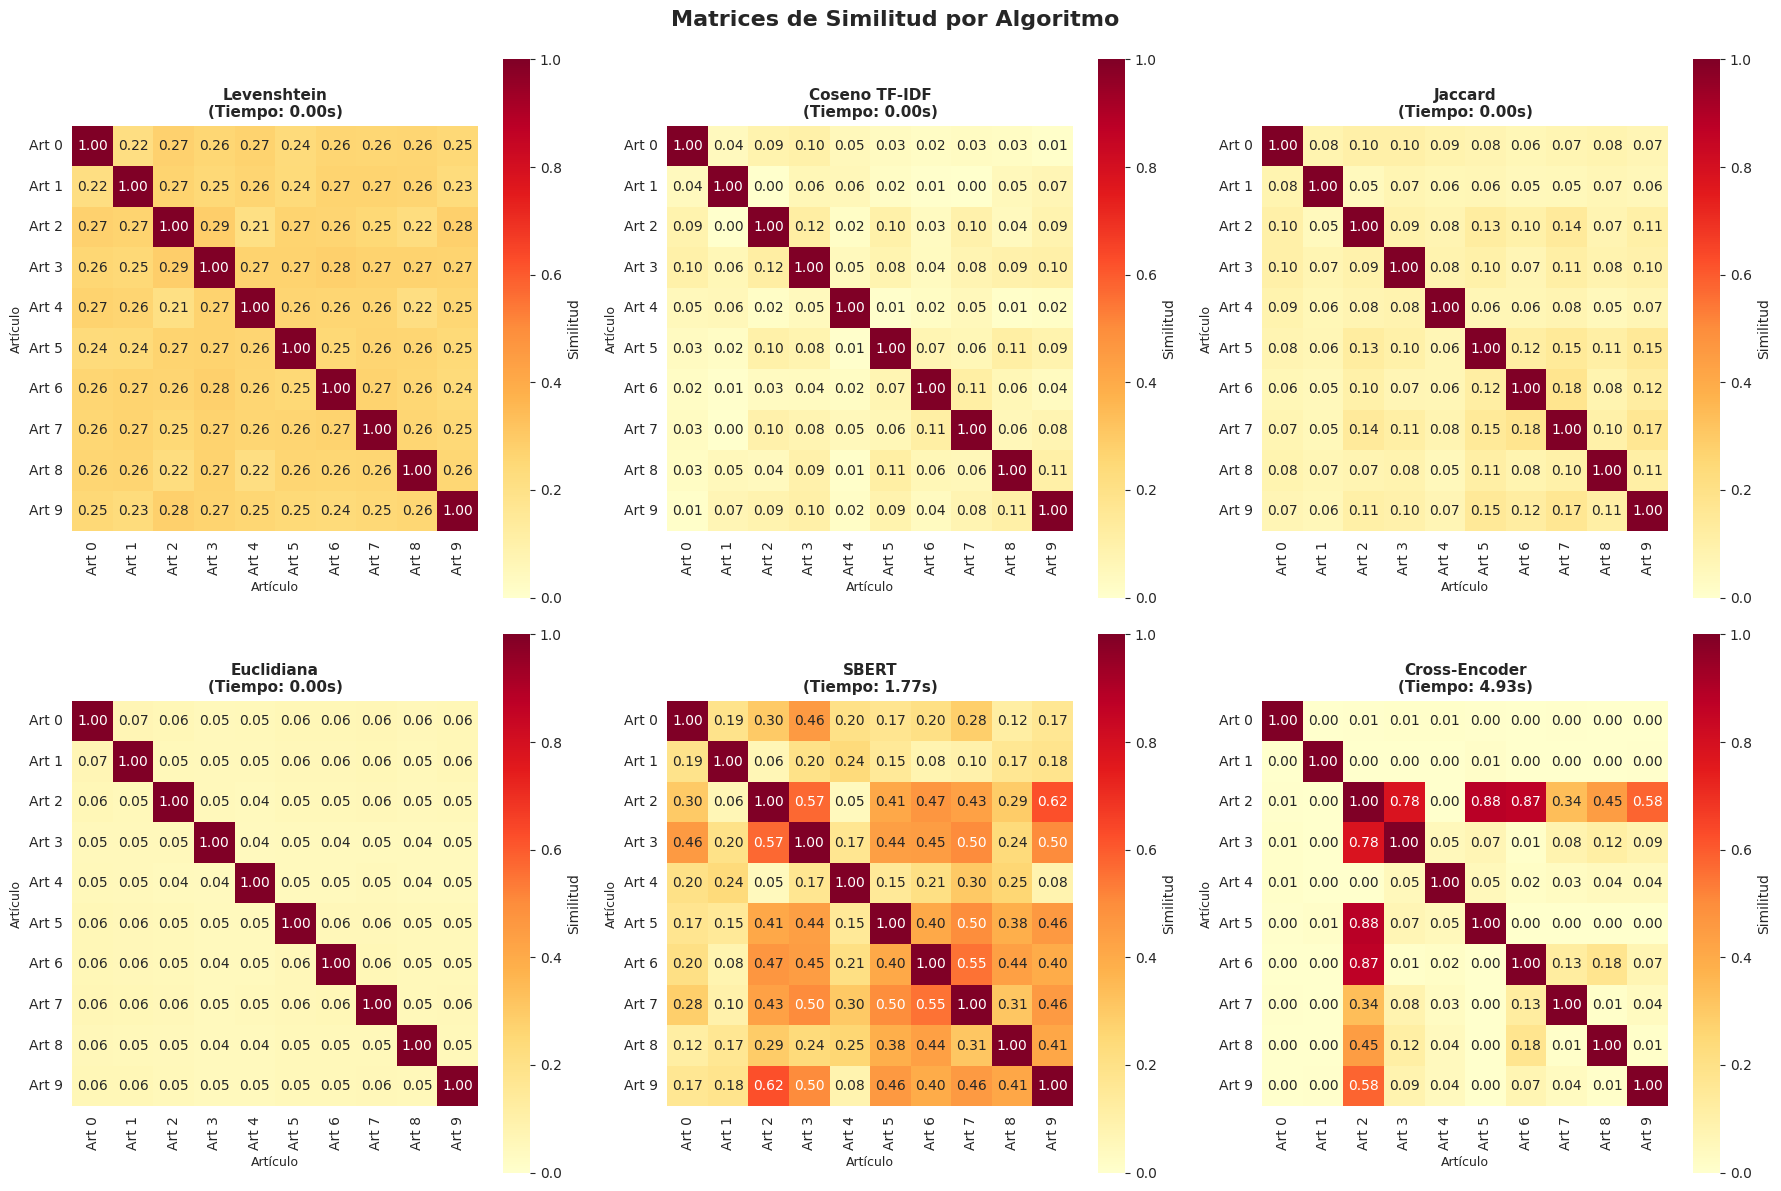


Interpretación de colores:
   Rojo oscuro (>=0.80): Muy similares
   Naranja (0.50-0.79): Similitud moderada
   Amarillo (0.20-0.49): Poco similares
   Blanco (<0.20): No similares


In [18]:
# Crear figura con subplots para cada algoritmo
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Matrices de Similitud por Algoritmo', fontsize=16, fontweight='bold', y=0.995)

# Etiquetas cortas para los artículos
labels = [f"Art {i}" for i in range(N_SAMPLES)]

algorithms = ['Levenshtein', 'Coseno TF-IDF', 'Jaccard', 'Euclidiana', 'SBERT', 'Cross-Encoder']

for idx, (ax, algo) in enumerate(zip(axes.flat, algorithms)):
    matrix = results[algo]['matrix']
    
    # Crear heatmap
    sns.heatmap(matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='YlOrRd', 
                vmin=0, 
                vmax=1,
                square=True,
                cbar_kws={'label': 'Similitud'},
                xticklabels=labels,
                yticklabels=labels,
                ax=ax)
    
    ax.set_title(f'{algo}\n(Tiempo: {results[algo]["time"]:.2f}s)', 
                 fontweight='bold', fontsize=11)
    ax.set_xlabel('Artículo', fontsize=9)
    ax.set_ylabel('Artículo', fontsize=9)

plt.tight_layout()
plt.show()

print("\nInterpretación de colores:")
print("   Rojo oscuro (>=0.80): Muy similares")
print("   Naranja (0.50-0.79): Similitud moderada")
print("   Amarillo (0.20-0.49): Poco similares")
print("   Blanco (<0.20): No similares")

## Tabla Comparativa Consolidada

Comparación lado a lado de todos los algoritmos para pares específicos de artículos.

In [19]:
# Crear tabla comparativa para los primeros 5 pares de artículos
comparison_data = []

# Seleccionar algunos pares representativos
pairs_to_compare = [(0, 1), (0, 2), (1, 2), (0, 5), (3, 7)]

for i, j in pairs_to_compare:
    if i < N_SAMPLES and j < N_SAMPLES:
        row = {
            'Par': f'{i} vs {j}',
            'Título 1': titles[i][:40] + '...',
            'Título 2': titles[j][:40] + '...',
        }
        
        for algo in algorithms:
            sim = results[algo]['matrix'][i][j]
            row[algo] = f'{sim:.3f}'
        
        comparison_data.append(row)

# Crear DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Mostrar tabla con estilo
print("TABLA COMPARATIVA DE SIMILITUDES\n")
print("=" * 150)
print(df_comparison.to_string(index=False))
print("=" * 150)

# Identificar el algoritmo con mayor y menor similitud para cada par
print("\nAnálisis por Par:\n")
for idx, row in df_comparison.iterrows():
    par = row['Par']
    similarities = {algo: float(row[algo]) for algo in algorithms}
    max_algo = max(similarities, key=similarities.get)
    min_algo = min(similarities, key=similarities.get)
    
    print(f"  {par}:")
    print(f"    Mayor similitud: {max_algo} ({similarities[max_algo]:.3f})")
    print(f"    Menor similitud: {min_algo} ({similarities[min_algo]:.3f})")
    print()

TABLA COMPARATIVA DE SIMILITUDES

   Par                                    Título 1                                    Título 2 Levenshtein Coseno TF-IDF Jaccard Euclidiana SBERT Cross-Encoder
0 vs 1 Do Robots Dream of Passing a Programming... WeAIR: Wearable Swarm Sensors for Air Qu...       0.219         0.042   0.078      0.070 0.189         0.001
0 vs 2 Do Robots Dream of Passing a Programming... Discriminative-Generative Representation...       0.274         0.089   0.105      0.060 0.297         0.006
1 vs 2 WeAIR: Wearable Swarm Sensors for Air Qu... Discriminative-Generative Representation...       0.266         0.004   0.046      0.054 0.064         0.003
0 vs 5 Do Robots Dream of Passing a Programming... Research of Low-light Image Enhancement ...       0.237         0.033   0.078      0.061 0.173         0.005
3 vs 7 3 Generative AI Models and LLM: Training... BCGAN: Facial Expression Synthesis by Bo...       0.272         0.078   0.111      0.046 0.502         0.084

Análi

## Análisis de Rendimiento

Comparación de tiempos de ejecución y eficiencia computacional.

/tmp/ipykernel_54218/3233831537.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(algorithms, rotation=45, ha='right')
/tmp/ipykernel_54218/3233831537.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(algorithms, rotation=45, ha='right')


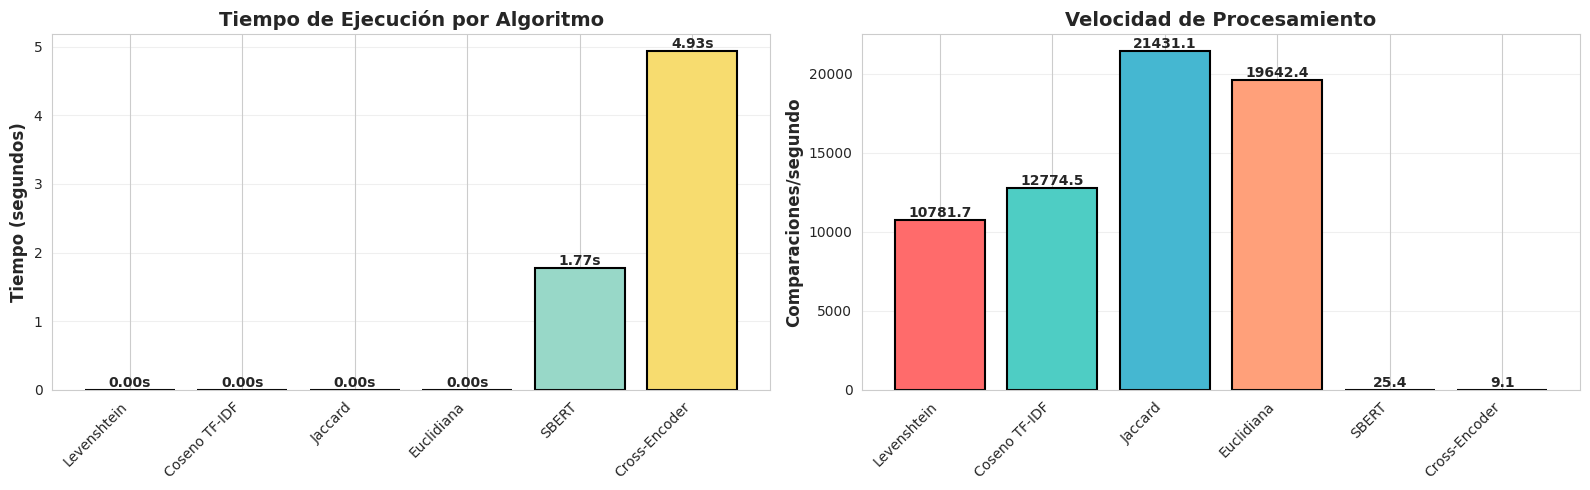


MÉTRICAS DE RENDIMIENTO

    Algoritmo Tiempo Total (s) Comparaciones/seg Tiempo por Par (ms)
  Levenshtein            0.004           10781.7                0.09
Coseno TF-IDF            0.004           12774.5                0.08
      Jaccard            0.002           21431.1                0.05
   Euclidiana            0.002           19642.4                0.05
        SBERT            1.773              25.4               39.40
Cross-Encoder            4.933               9.1              109.62

Ranking de Velocidad:
  1. Jaccard: 0.002s
  2. Euclidiana: 0.002s
  3. Coseno TF-IDF: 0.004s
  4. Levenshtein: 0.004s
  5. SBERT: 1.773s
  6. Cross-Encoder: 4.933s


In [20]:
# Gráfico de barras de tiempos de ejecución
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico 1: Tiempos de ejecución
times = [results[algo]['time'] for algo in algorithms]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

bars = ax1.bar(algorithms, times, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Tiempo (segundos)', fontsize=12, fontweight='bold')
ax1.set_title('Tiempo de Ejecución por Algoritmo', fontsize=14, fontweight='bold')
ax1.set_xticklabels(algorithms, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Agregar valores sobre las barras
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.2f}s',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Gráfico 2: Comparación de velocidad (operaciones por segundo)
n_comparisons = N_SAMPLES * (N_SAMPLES - 1) / 2  # Número de pares únicos
ops_per_sec = [n_comparisons / results[algo]['time'] if results[algo]['time'] > 0 else 0 
               for algo in algorithms]

bars2 = ax2.bar(algorithms, ops_per_sec, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Comparaciones/segundo', fontsize=12, fontweight='bold')
ax2.set_title('Velocidad de Procesamiento', fontsize=14, fontweight='bold')
ax2.set_xticklabels(algorithms, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Agregar valores sobre las barras
for bar, ops in zip(bars2, ops_per_sec):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{ops:.1f}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Tabla de rendimiento
print("\nMÉTRICAS DE RENDIMIENTO\n")
print("=" * 80)
perf_data = []
for algo in algorithms:
    perf_data.append({
        'Algoritmo': algo,
        'Tiempo Total (s)': f"{results[algo]['time']:.3f}",
        'Comparaciones/seg': f"{n_comparisons / results[algo]['time']:.1f}",
        'Tiempo por Par (ms)': f"{(results[algo]['time'] / n_comparisons) * 1000:.2f}"
    })

df_perf = pd.DataFrame(perf_data)
print(df_perf.to_string(index=False))
print("=" * 80)

# Ranking de velocidad
print("\nRanking de Velocidad:")
sorted_algos = sorted(algorithms, key=lambda x: results[x]['time'])
for rank, algo in enumerate(sorted_algos, 1):
    print(f"  {rank}. {algo}: {results[algo]['time']:.3f}s")

## Análisis Estadístico

Estadísticas descriptivas de las similitudes calculadas por cada algoritmo.

ESTADÍSTICAS DESCRIPTIVAS DE SIMILITUDES

    Algoritmo  Media Mediana Desv. Est. Mínimo Máximo Q1 (25%) Q3 (75%)
  Levenshtein 0.2566  0.2602     0.0167 0.2082 0.2853   0.2490   0.2674
Coseno TF-IDF 0.0553  0.0487     0.0344 0.0019 0.1210   0.0266   0.0853
      Jaccard 0.0901  0.0811     0.0314 0.0457 0.1784   0.0674   0.1066
   Euclidiana 0.0526  0.0529     0.0062 0.0400 0.0697   0.0471   0.0563
        SBERT 0.3046  0.2895     0.1541 0.0458 0.6217   0.1730   0.4379
Cross-Encoder 0.1111  0.0113     0.2282 0.0003 0.8826   0.0015   0.0739


/tmp/ipykernel_54218/3716809213.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=algorithms, patch_artist=True,


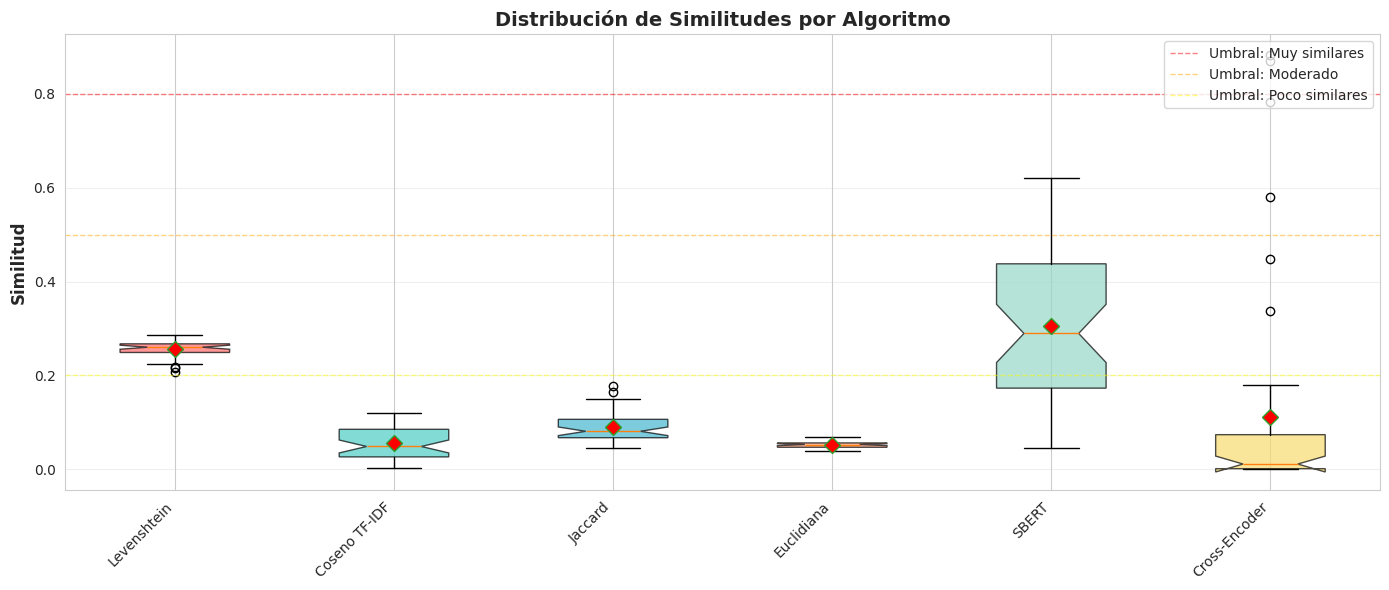


Interpretación:
   Diamante rojo: Media de similitudes
   Línea central: Mediana
   Caja: Rango intercuartílico (Q1-Q3)
   Bigotes: Rango de valores (excluyendo outliers)
   Círculos: Valores atípicos (outliers)


In [21]:
# Extraer valores de similitud (excluyendo diagonal)
stats_data = []

for algo in algorithms:
    matrix = results[algo]['matrix']
    # Obtener triángulo superior (sin diagonal)
    similarities = []
    for i in range(N_SAMPLES):
        for j in range(i+1, N_SAMPLES):
            similarities.append(matrix[i][j])
    
    similarities = np.array(similarities)
    
    stats_data.append({
        'Algoritmo': algo,
        'Media': f"{np.mean(similarities):.4f}",
        'Mediana': f"{np.median(similarities):.4f}",
        'Desv. Est.': f"{np.std(similarities):.4f}",
        'Mínimo': f"{np.min(similarities):.4f}",
        'Máximo': f"{np.max(similarities):.4f}",
        'Q1 (25%)': f"{np.percentile(similarities, 25):.4f}",
        'Q3 (75%)': f"{np.percentile(similarities, 75):.4f}"
    })

df_stats = pd.DataFrame(stats_data)

print("ESTADÍSTICAS DESCRIPTIVAS DE SIMILITUDES\n")
print("=" * 120)
print(df_stats.to_string(index=False))
print("=" * 120)

# Visualización: Boxplot comparativo
fig, ax = plt.subplots(figsize=(14, 6))

# Preparar datos para boxplot
boxplot_data = []
for algo in algorithms:
    matrix = results[algo]['matrix']
    similarities = []
    for i in range(N_SAMPLES):
        for j in range(i+1, N_SAMPLES):
            similarities.append(matrix[i][j])
    boxplot_data.append(similarities)

bp = ax.boxplot(boxplot_data, labels=algorithms, patch_artist=True,
                notch=True, showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Colorear las cajas
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Similitud', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Similitudes por Algoritmo', fontsize=14, fontweight='bold')
ax.set_xticklabels(algorithms, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Umbral: Muy similares')
ax.axhline(y=0.5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Umbral: Moderado')
ax.axhline(y=0.2, color='yellow', linestyle='--', linewidth=1, alpha=0.5, label='Umbral: Poco similares')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Interpretación
print("\nInterpretación:")
print("   Diamante rojo: Media de similitudes")
print("   Línea central: Mediana")
print("   Caja: Rango intercuartílico (Q1-Q3)")
print("   Bigotes: Rango de valores (excluyendo outliers)")
print("   Círculos: Valores atípicos (outliers)")

## Correlación entre Algoritmos

Análisis de qué tan similares son los resultados entre diferentes algoritmos.

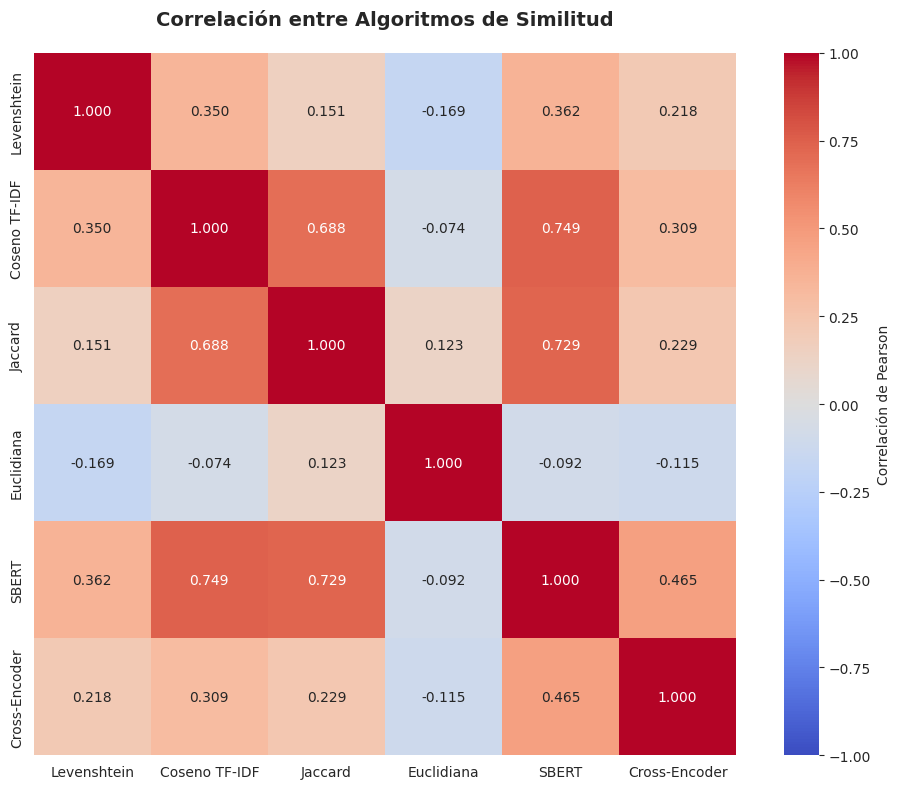


ANÁLISIS DE CORRELACIÓN ENTRE ALGORITMOS


Pares con MAYOR correlación (resultados más similares):
                      Par  Correlación
  Coseno TF-IDF <-> SBERT     0.749486
        Jaccard <-> SBERT     0.729116
Coseno TF-IDF <-> Jaccard     0.688338
  SBERT <-> Cross-Encoder     0.465015
    Levenshtein <-> SBERT     0.361844


Pares con MENOR correlación (resultados más diferentes):
                         Par  Correlación
      Jaccard <-> Euclidiana     0.123234
Coseno TF-IDF <-> Euclidiana    -0.073780
        Euclidiana <-> SBERT    -0.092139
Euclidiana <-> Cross-Encoder    -0.115313
  Levenshtein <-> Euclidiana    -0.168665


Interpretación:
   Correlación cercana a +1: Los algoritmos dan resultados muy similares
   Correlación cercana a 0: Los algoritmos dan resultados independientes
   Correlación cercana a -1: Los algoritmos dan resultados opuestos


In [22]:
# Calcular correlación entre algoritmos
correlation_matrix = np.zeros((len(algorithms), len(algorithms)))

for i, algo1 in enumerate(algorithms):
    for j, algo2 in enumerate(algorithms):
        # Extraer valores del triángulo superior
        vals1 = []
        vals2 = []
        for x in range(N_SAMPLES):
            for y in range(x+1, N_SAMPLES):
                vals1.append(results[algo1]['matrix'][x][y])
                vals2.append(results[algo2]['matrix'][x][y])
        
        # Calcular correlación de Pearson
        correlation_matrix[i][j] = np.corrcoef(vals1, vals2)[0, 1]

# Visualizar matriz de correlación
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.3f', 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1,
            square=True,
            cbar_kws={'label': 'Correlación de Pearson'},
            xticklabels=algorithms,
            yticklabels=algorithms,
            ax=ax)

ax.set_title('Correlación entre Algoritmos de Similitud', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Encontrar pares con mayor y menor correlación
print("\nANÁLISIS DE CORRELACIÓN ENTRE ALGORITMOS\n")
print("=" * 80)

correlations = []
for i in range(len(algorithms)):
    for j in range(i+1, len(algorithms)):
        correlations.append({
            'Par': f"{algorithms[i]} <-> {algorithms[j]}",
            'Correlación': correlation_matrix[i][j]
        })

df_corr = pd.DataFrame(correlations).sort_values('Correlación', ascending=False)

print("\nPares con MAYOR correlación (resultados más similares):")
print(df_corr.head(5).to_string(index=False))

print("\n\nPares con MENOR correlación (resultados más diferentes):")
print(df_corr.tail(5).to_string(index=False))

print("\n" + "=" * 80)
print("\nInterpretación:")
print("   Correlación cercana a +1: Los algoritmos dan resultados muy similares")
print("   Correlación cercana a 0: Los algoritmos dan resultados independientes")
print("   Correlación cercana a -1: Los algoritmos dan resultados opuestos")